# Rift identification using Random Forest

This notebook employs the Random Forest algorithm, an ensemble machine learning method, to classify ICESat-2 tracks based on whether they pass over rifts or not. We start by selecting the number of decision trees to include in our forest:

In [1]:
trees = 50 #choose the number of decision trees

We then import all necessary packages and modules: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

and set paths as necessary.

In [3]:
root_path = '/data/fast1/rift-id/'
outputs_path = root_path + 'outputs' #where the training data are stored

## Step 1: Load training data (rifted ice)

The first dataset consists of ICESat-2 tracks, each representing a series of surface elevation measurements along a linear profile. These profiles have been manually labeled to indicate which coordinates fall within rifts, and which do not (see the plot a few cells down). 

In [4]:
training_data = pd.read_pickle(outputs_path + '/dml_all_bin_lr.pkl') #load the training data with rifted ice
display(training_data.head()) #and display some of its contents below

,shelf,rift,trace_nr,rgt,beam,cycle,x_subset,y_subset,d_subset,h_subset,coords,rift_width,bin_subset
0,dml,F3a,251.0,854.0,3l,8.0,"[-35051.9507797757, -35054.69159288903, -35057...","[2209801.822420919, 2209821.6137664495, 220984...","[2210079.802547474, 2210099.6348744165, 221011...","[37.8853027194217, 37.80916926938781, 37.71423...","[[2214751.7884001248, 36.35006877579091], [221...",624.383781,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,dml,F3a,257.0,907.0,1l,8.0,"[-36176.617142950425, -36178.70181675851, -361...","[2219700.378208351, 2219680.5043959934, 221966...","[2219995.1614015293, 2219975.324200879, 221995...","[35.95811775961225, 35.95619088014532, 35.9472...","[[2214687.1412469666, 34.79023383768912], [221...",641.490186,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,dml,F3a,318.0,1296.0,1r,4.0,"[-31740.226040771147, -31743.018613824494, -31...","[2209875.7924229424, 2209895.5737409526, 22099...","[2210103.721522148, 2210123.5409068363, 221014...","[39.874198151842805, 39.8879744656365, 39.8297...","[[2214744.7319527855, 39.209766162310856], [22...",667.149793,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,dml,F3a,258.0,907.0,1r,8.0,"[-36268.06361407608, -36270.205783219826, -362...","[2219669.882548686, 2219650.0148718944, 221963...","[2219966.1618889626, 2219946.331862182, 221992...","[36.04938743890687, 36.05862249905419, 36.0207...","[[2214654.730072184, 34.98521320495185], [2215...",675.702995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,dml,F3a,235.0,854.0,3l,3.0,"[-34920.31000628142, -34923.13998048323, -3492...","[2208892.2175512146, 2208911.9957032157, 22089...","[2209168.227367318, 2209188.04778309, 2209207....","[37.48623879428231, 37.424937917146465, 37.330...","[[2213817.998200497, 35.83012379642365], [2214...",675.702995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


While there is a lot of info contained in this dataset, the crucial piece of information is ```h_subset```, which records the elevation profile along a given track. We'll save these data to a separate array, and also nondimensionalize the result by dividing each elevation profile by its maximal value:

In [5]:
elevation_profiles = training_data['h_subset'] #surface elevations along each track
elevation_profiles_1 = np.array([profile/np.max(profile) for profile in elevation_profiles]) #where '1' indicates rifted ice

### Plot an example rift

Text(0.5, 1.0, 'rift F3a')

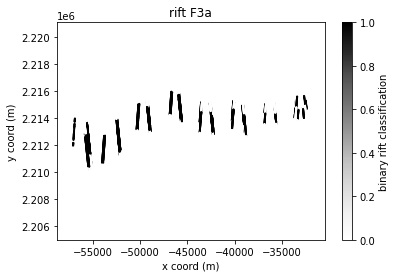

In [6]:
chosen_rift = 'F3a' #we arbitrarily choose this rift name from the table above

rift_names = training_data['rift'] #the names of each rift
x, y = training_data['x_subset'], training_data['y_subset'] #x and y coordinates along each track
labels = training_data['bin_subset']
plt.figure()

for i in range(len(elevation_profiles_1)):
    if rift_names[i] == chosen_rift:
        plt.scatter(x[i], y[i], s = 1, c = labels[i], cmap = 'Greys')
cbar = plt.colorbar()
cbar.set_label('binary rift classification')
plt.xlabel('x coord (m)')
plt.ylabel('y coord (m)')
plt.title(f'rift {chosen_rift}')

## Step 2: Load training data (non-rifted ice)

Similar to the rifted-ice data, except that these tracks have been manually-verified to not pass over any rifts. 

In [7]:
training_data = pd.read_pickle(outputs_path + '/dml_all_bin_lr_nonrift.pkl') #load the non-rift training data
display(training_data.head()) #and display

,shelf,trace_nr,rgt,beam,cycle,x_subset,y_subset,d_subset,h_subset
0,dml,3,343,1l,1,"[7189.130619388052, 7186.582485923817, 7184.05...","[2178538.164580444, 2178518.367937365, 2178498...","[2178550.0265388885, 2178530.221596273, 217851...","[48.61846717820136, 48.629136266546986, 48.685..."
1,dml,3,343,1l,1,"[10771.061710737451, 10768.46265320321, 10765....","[2206342.992558727, 2206323.1867494155, 220630...","[2206369.283819773, 2206349.4655597988, 220632...","[39.312748235934464, 39.36207013152795, 39.436..."
2,dml,4,343,1r,1,"[1545.5180160965535, 1542.9408661270236, 1540....","[2135298.5680844295, 2135278.7991766883, 21352...","[2135299.1274033138, 2135279.356636962, 213525...","[61.566919891431056, 61.65171745137367, 61.668..."
3,dml,4,343,1r,1,"[4613.970076180094, 4611.471113110717, 4608.96...","[2159313.6893266398, 2159293.8971956973, 21592...","[2159318.618831711, 2159298.821407637, 2159279...","[54.380458381895046, 54.431472361310135, 54.38..."
4,dml,4,343,1r,1,"[11211.057107959065, 11208.581233071916, 11206...","[2210596.637684287, 2210576.8136304324, 221055...","[2210625.0659807855, 2210605.229626885, 221058...","[37.515234850604074, 37.533068170604736, 37.57..."


In [8]:
elevation_profiles = training_data['h_subset'] #surface elevations along each track
elevation_profiles_0 = np.array([profile/np.max(profile) for profile in elevation_profiles]) #where '0' indicates non-rift

### Plot an example non-rift

Text(0.5, 0, 'distance along track (m)')

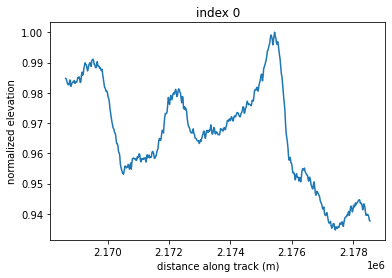

In [9]:
index = 0

dist = training_data['d_subset']

plt.figure()
plt.plot(dist[index], elevation_profiles_0[index])
plt.title(f'index {index}')
plt.ylabel('normalized elevation')
plt.xlabel('distance along track (m)')

## Step 3: Define and train the model

We compile all the data into two lists for training the rift classification model. The first list contains all surface elevation profiles, including those with and without rifts. The second list consists of binary labels, where ```1``` indicates profiles that contain rifts and ```0``` indicates profiles without rifts. 

In [10]:
elevation_profiles = np.concatenate([elevation_profiles_0, elevation_profiles_1]) #concatenate all surface elevation profiles
labels = np.concatenate([np.zeros(len(elevation_profiles_0)), np.ones(len(elevation_profiles_1))])

training_data = {
    'features': elevation_profiles,
    'labels': labels
}

X_train, X_test, Y_train, Y_test = train_test_split(training_data['features'], training_data['labels'], 
                                                    test_size = 0.2, random_state=0)
model = RandomForestClassifier(n_estimators = trees)

score = 1
while score == 1: #temporarily tweaking this to avoid getting a 'perfect' model
    model.fit(X_train, Y_train)
    score = model.score(X_test,Y_test)

## Step 4: Investigate model performance

We first display the confusion matrix, and then we specifically examine one example from each quadrant (where applicable). 

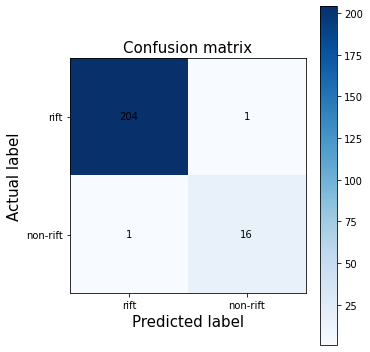

In [11]:
Y_predicted = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['rift', 'non-rift'], size=10)
plt.yticks(tick_marks, ['rift', 'non-rift'], size=10)
plt.tight_layout()
plt.ylabel('Actual label', size=15)
plt.xlabel('Predicted label', size=15)
width, height = cm.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x),
                     horizontalalignment='center',
                     verticalalignment='center')

plt.show()

### See where data are correctly/incorrectly classified

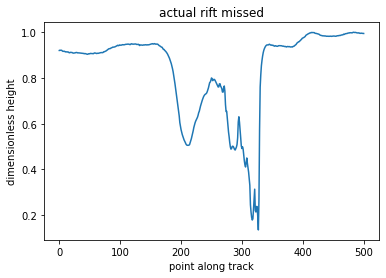

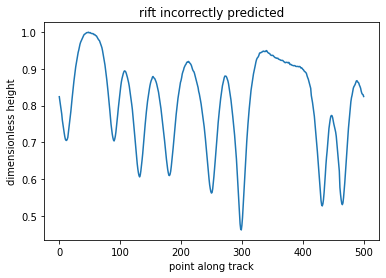

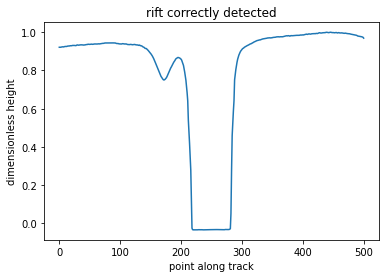

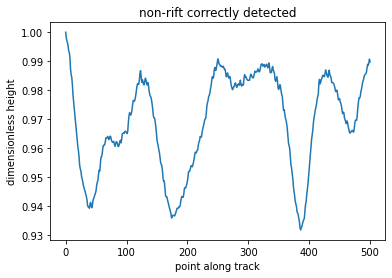

In [12]:
false_positive_indices = np.where((Y_test == 0) & (Y_predicted != 0))[0] #actually no rift, but rift predicted
false_negative_indices = np.where((Y_test == 1) & (Y_predicted != 1))[0] #actually a rift, but none predicted
true_positive_indices = np.where((Y_test == 1) & (Y_predicted == 1))[0] #actually a rift, and rift predicted
true_negative_indices = np.where((Y_test == 0) & (Y_predicted == 0))[0] #actually no rift, and none predicted

try:
    plt.figure()
    plt.plot(X_test[false_negative_indices[0]]) #plot the data corresponding to the false negative
    plt.title('actual rift missed')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass

try:
    plt.figure()
    plt.plot(X_test[false_positive_indices[0]]) #etc.
    plt.title('rift incorrectly predicted')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass

try:
    plt.figure()
    plt.plot(X_test[true_positive_indices[0]])
    plt.title('rift correctly detected')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass

try:
    plt.figure()
    plt.plot(X_test[true_negative_indices[0]])
    plt.title('non-rift correctly detected')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass